In [1]:
import os
from numpy import genfromtxt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import resample
from utils import plot_confusion_matrix, plot_confusion_matrix, get_gzipped_model_size
from data_organizer_Kfall import DataOrganizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import models, optimizers, callbacks
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import StandardScaler
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks


2023-12-10 21:13:26.128069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 21:13:26.128129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 21:13:26.129285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 21:13:26.142344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 21:13:27.116468: W tensorflow/compiler/tf2

# Model Select

In [2]:
model_name = "TinyFallNet" # "ConvLSTM" or "ConvLSTM_VGG" or "TinyFallNet" or "ResNet24"

if model_name == "ConvLSTM":
    from models.ConvLSTM import ConvLSTM
    model = ConvLSTM()
elif model_name == "ConvLSTM_VGG":
    from models.ConvLSTM_VGG import ConvLSTM_VGG
    model = ConvLSTM_VGG()
elif model_name == "TinyFallNet":
    from models.TinyFallNet import TinyFallNet
    model = TinyFallNet()
elif model_name == "ResNet24":
    from models.ResNet24 import ResNet24
    model = ResNet24()
else:
    print("Please select a valid model name")


2023-12-10 21:13:32.676885: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 21:13:32.733868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 21:13:32.733945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 21:13:32.737967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 21:13:32.738149: I external/local_xla/xla/stream_executor

# Data Loader

In [3]:
# mac
# sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
# label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
#sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
#label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

in_channels = 9
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, 9)
# normalize the data
# Initialize a new scaling object for normalizing input data
# Z-score normalization

# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)

X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...
in_channels:  9
data.shape:  (25602, 50, 9)
B_size:  25020
A_size:  582
data:  [ 3.40000000e-02 -1.02800000e+00 -3.70000000e-02 -2.29183200e+00
 

# Hyperparameters

In [4]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# Model Training

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
            loss='categorical_crossentropy',
            #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.build(input_shape=(None, 50, 9))
model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 50, 9)             0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1, 48, 64)            1792      ['reshape[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 1, 24, 64)            0         ['conv2d[0][0]']              
 D)                                                                                     

In [17]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}

# Ensure y_train and y_val are one-hot encoded only once
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16384, 2)
y_val.shape:  (4097, 2)
X_train.shape:  (16384, 50, 9)
y_train.shape:  (16384, 2)
Epoch 1/50
256/256 [==============================] - 13s 23ms/step - loss: 1.5761 - accuracy: 0.8129 - val_loss: 0.3823 - val_accuracy: 0.8994 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 21ms/step - loss: 0.7098 - accuracy: 0.8772 - val_loss: 0.4687 - val_accuracy: 0.8665 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 21ms/step - loss: 0.5412 - accuracy: 0.8978 - val_loss: 0.3020 - val_accuracy: 0.8980 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 5s 20ms/step - loss: 0.4720 - accuracy: 0.9099 - val_loss: 0.1643 - val_accuracy: 0.9497 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 5s 19ms/step - loss: 0.3963 - accuracy: 0.9252 - val_loss: 0.1255 - val_accuracy: 0.9644 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 5s 19ms/step - loss: 0.4374 - accura

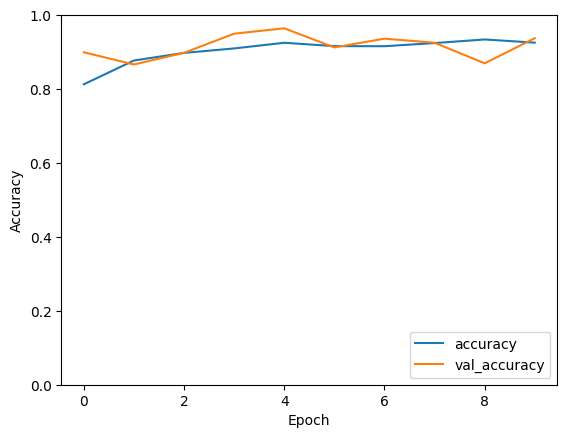

In [18]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Model Evaluation

In [19]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (230, 50, 9)
8/8 - 1s - loss: 0.1997 - accuracy: 0.9478 - 553ms/epoch - 69ms/step
Test loss: [0.19974111020565033, 0.947826087474823]


8/8 [==============================] - 0s 5ms/step
[[107   5]
 [  7 111]]
Confusion matrix, without normalization
[[107   5]
 [  7 111]]
accuracy:  0.9478260869565217
f1_score:  0.9487179487179486


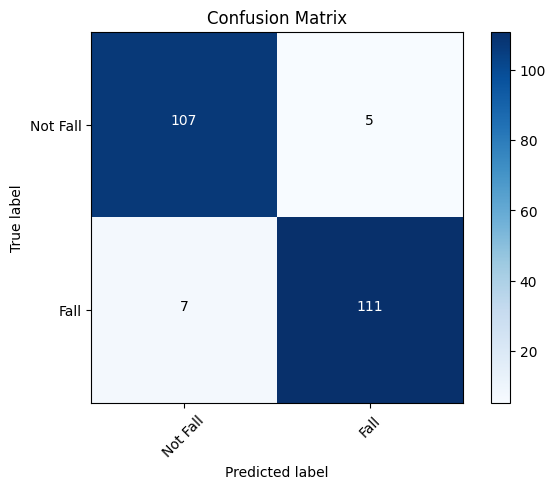

In [20]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(model.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)


# Save Model

In [21]:
model.save('./saved_models/'+model_name+'.keras')
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if model_name=="ConvLSTM_VGG":
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_tflite = converter.convert()
# save the model
open('./saved_models/'+model_name+'.tflite', "wb").write(model_tflite)


INFO:tensorflow:Assets written to: /tmp/tmpdowdryw2/assets


INFO:tensorflow:Assets written to: /tmp/tmpdowdryw2/assets
2023-12-10 20:49:09.076616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 20:49:09.076676: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 20:49:09.076894: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdowdryw2
2023-12-10 20:49:09.081684: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 20:49:09.081708: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpdowdryw2
2023-12-10 20:49:09.103466: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 20:49:09.340391: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpdowdryw2
2023-12-10 20:49:09.414378: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

141308

# Quantization

In [22]:
model = models.load_model('./saved_models/'+model_name+'.keras')
q_model = tfmot.quantization.keras.quantize_model(model)
q_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 50, 9)                3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 9)             1         ['quantize_layer[0][0]']      
 pperV2)                                                                                          
                                                                                        

In [23]:
q_model.save('./saved_models/'+model_name+'_q.keras')
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /tmp/tmpr12l9ff_/assets


INFO:tensorflow:Assets written to: /tmp/tmpr12l9ff_/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-10 20:49:48.662043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 20:49:48.662131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 20:49:48.662401: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpr12l9ff_
2023-12-10 20:49:48.674117: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 20:49:48.674149: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpr12l9ff_
2023-12-10 20:49:48.714119: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bun

input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


69624

# QAT

In [24]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

q_history = q_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

y_train.shape:  (16384, 2)
y_val.shape:  (4097, 2)
Epoch 1/50
256/256 [==============================] - 31s 88ms/step - loss: 0.7379 - accuracy: 0.8407 - val_loss: 0.2523 - val_accuracy: 0.8938 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 22s 85ms/step - loss: 0.4672 - accuracy: 0.8992 - val_loss: 0.2058 - val_accuracy: 0.9199 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 22s 87ms/step - loss: 0.3603 - accuracy: 0.9186 - val_loss: 0.3481 - val_accuracy: 0.8926 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 23s 89ms/step - loss: 0.3387 - accuracy: 0.9258 - val_loss: 0.2232 - val_accuracy: 0.9295 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 22s 86ms/step - loss: 0.3083 - accuracy: 0.9333 - val_loss: 0.1550 - val_accuracy: 0.9522 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 22s 85ms/step - loss: 0.3756 - accuracy: 0.9184 - val_loss: 0.1782 - val_accuracy: 0.9412 

In [25]:
q_model.save('./saved_models/'+model_name+'_qat.keras')  # The file needs to end with the .keras extension
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_qat.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /tmp/tmpqckl5l3y/assets


INFO:tensorflow:Assets written to: /tmp/tmpqckl5l3y/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


2023-12-10 20:55:36.232474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 20:55:36.232533: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 20:55:36.232703: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqckl5l3y
2023-12-10 20:55:36.242056: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 20:55:36.242085: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpqckl5l3y
2023-12-10 20:55:36.286959: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 20:55:36.730047: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpqckl5l3y
2023-12-10 20:55:36.862110: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 629409 

69912

# Prune

In [26]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 9)             1         ['input_1[0][0]']             
 e (PruneLowMagnitude)                                                                            
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            3522      ['prune_low_magnitude_reshape[
  (PruneLowMagnitude)                                               0][0]']                       
                                                                                        

In [27]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 27s 47ms/step - loss: 0.4478 - accuracy: 0.9227 - val_loss: 0.2168 - val_accuracy: 0.9375 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 11s 44ms/step - loss: 0.4022 - accuracy: 0.9233 - val_loss: 0.2707 - val_accuracy: 0.9221 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 11s 45ms/step - loss: 0.2752 - accuracy: 0.9426 - val_loss: 0.1428 - val_accuracy: 0.9609 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 11s 43ms/step - loss: 0.2892 - accuracy: 0.9426 - val_loss: 0.1520 - val_accuracy: 0.9492 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 11s 43ms/step - loss: 0.2797 - accuracy: 0.9425 - val_loss: 0.1757 - val_accuracy: 0.9512 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 12s 45ms/step - loss: 0.2852 - accuracy: 0.9418 - val_loss: 0.1789 - val_accuracy: 0.9470 - lr: 5.0000e-04
Epoch 7/50
256/256 [==============

In [28]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)

Pruned model loss:  0.3292510509490967
Pruned model accuracy:  0.8826087117195129
Full-precision model accuracy:  0.9478260869565217


In [29]:
# save the model
pruned_model_unstructured.save('./saved_models/'+model_name+'_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = './saved_models/'+model_name+'_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

# print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))


INFO:tensorflow:Assets written to: /tmp/tmp0y0b2zhp/assets


INFO:tensorflow:Assets written to: /tmp/tmp0y0b2zhp/assets


Size of the unstructured pruned model:  77733
Size of the full-precision model:  122558
The achieved compression ratio is 1.00x


2023-12-10 20:58:31.296864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 20:58:31.296915: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 20:58:31.297089: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0y0b2zhp
2023-12-10 20:58:31.300618: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 20:58:31.300650: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0y0b2zhp
2023-12-10 20:58:31.314618: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-10 20:58:31.433746: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0y0b2zhp
2023-12-10 20:58:31.484502: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 187413 

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('./saved_models/'+model_name+'.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite')))


# PQAT

In [30]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_1 (Quantize  (None, 50, 9)                3         ['input_1[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 9)             1         ['quantize_layer_1[0][0]']    
 pperV2)                                                                                          
                                                                                        

In [31]:
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 


X_train.shape:  (16384, 50, 9)
y_train.shape:  (16384, 2)
64
Epoch 1/50
256/256 [==============================] - 33s 93ms/step - loss: 0.7766 - accuracy: 0.8300 - val_loss: 0.2036 - val_accuracy: 0.9177 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 22s 88ms/step - loss: 0.3962 - accuracy: 0.9116 - val_loss: 0.1793 - val_accuracy: 0.9348 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 23s 90ms/step - loss: 0.3216 - accuracy: 0.9235 - val_loss: 0.1662 - val_accuracy: 0.9402 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 23s 92ms/step - loss: 0.3149 - accuracy: 0.9293 - val_loss: 0.1733 - val_accuracy: 0.9414 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 24s 94ms/step - loss: 0.2542 - accuracy: 0.9425 - val_loss: 0.1353 - val_accuracy: 0.9556 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 24s 93ms/step - loss: 0.2329 - accuracy: 0.9481 - val_loss: 0.1548 - val_accurac

In [32]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(X_test, y_test, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', accuracy_fp)


Pruned QAT model loss:  0.22536268830299377
Pruned QAT model accuracy:  0.9217391014099121
Full-precision model accuracy:  0.9478260869565217


In [33]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
open('./saved_models/'+model_name+'_pqat.tflite', "wb").write(pruned_qat_tflite_model)

# write TFLite model to a C source (or header) file
#c_model_name = 'pruned_qat_fmnist'

#with open('cfiles/' + c_model_name + '.h', 'w') as file:
#    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))


INFO:tensorflow:Assets written to: /tmp/tmp0ovnamy2/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ovnamy2/assets
/home/liyinrong/miniconda3/envs/tensorflow-dev/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-10 21:05:13.995673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-10 21:05:13.995750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-10 21:05:13.996096: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0ovnamy2
2023-12-10 21:05:14.009020: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-10 21:05:14.009069: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0ovnamy2
2023-12-10 21:05:14.060891: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bun

70096

input:  {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 50,  9], dtype=int32), 'shape_signature': array([-1, 50,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 75, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 .
[[107   5]
 [ 12 106]]
Confusion matrix, without normalization
[[107   5]
 [ 12 106]]
f1_score:  0.925764192139738


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


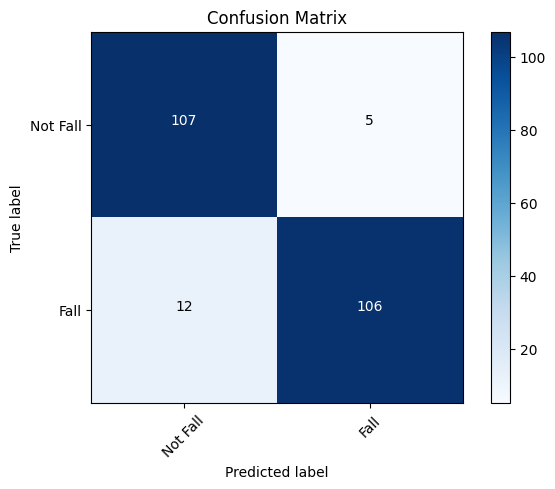

In [34]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= pruned_qat_tflite_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


In [35]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite'))
print('Size of th QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_qat.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/TinyFallNet.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite')))


Size of the pruned QAT model:  33696
Size of th QAT model:  43330
Size of the full-precision model:  122558
The achieved compression ratio is 3.64x
